# ANÁLISE DOS REGISTROS DO SISTEMA COMANDO DE OCORRÊNCIAS COM ORIGEM METEOROLÓGICA

---
### Notebook Sections:
1. Exploratory data analysis & data cleaning
    * Asses general quality of the dataset
2. Extract incident catalog
    * Extract catalog of incidents with known coordinates, caused by rain for predicive modeling
3. Reverse geocode catalog coordinates
4. Reverse geocode result analysis
5. Filter and merge geocode result to catalog
    * Obs: Exclude incidents without a numbered address result
4. Extra: Search in text based records for incidents left out of initial extraction 
5. Extra: Search catalog for incidents indentified by city cameras

### Import modules and functions

In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt#, requests, json, folium
import seaborn as sns; sns.set()
# from folium import plugins
from IPython.display import clear_output as co

### Definir classe 'data' com endereço dos dados
class DATA:
    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

### Load data

In [2]:
comando = pd.read_csv(DATA.path + 'comando.csv')

c:\Users\luisr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


---
# 1. Exploratory Data Analysis & Data Cleaning

### 0. Extract records of incidents caused by metheorological events

In [3]:
titles = [
    "Bolsão d'água em via", 'Vazamento de água / esgoto',
    'Alagamentos e enchentes', "Lâmina d'água",
    "Lâmina d'água em via", 'Alagamento',
    'Enchente', 'Bueiro'
]

records = comando[comando['POP_TITULO'].isin(titles)].copy()
records_left = comando.loc[set(comando.index).difference(records.index)].copy()

data = records.reset_index(drop=False).rename(columns={'index': 'REGISTRO_ID'}).copy()
comando = None

print(records.shape) # Número total de registros encontrados

(12409, 18)


**Key findings**:
1. The record history of incidents caused by rain has some overlaping categories for incident type. There is a need to confirm the reason for the overlaping categories with the institution.

### 1. Asses data types

##### Identify variables' types

In [4]:
cols = {
    'text': [
        'EVENTO_TITULO', 'EVENTO_DESCRICAO'
    ],
    'categorical': [
        'EVENTO_GRAVIDADE', 'EVENTO_BAIRRO', 'STATUS', 'EVENTO_PRAZO',
        'POP_TITULO', 'POP_DESCRICAO', 'ORGAO_SIGLA', 'ORGAO_NOME', 'ACAO'
    ],
    'datetime': [
        'EVENTO_INICIO', 'EVENTO_INICIO_HORA',
        'EVENTO_FIM', 'EVENTO_FIM_HORA'
    ],
    'location': [
        'EVENTO_LATITUDE', 'EVENTO_LONGITUDE'
    ]
}

#### Check raw data types

In [5]:
data.dtypes

REGISTRO_ID             int64
EVENTO_ID               int64
EVENTO_TITULO          object
EVENTO_DESCRICAO       object
EVENTO_GRAVIDADE       object
EVENTO_BAIRRO          object
STATUS                 object
EVENTO_INICIO          object
EVENTO_INICIO_HORA     object
EVENTO_FIM             object
EVENTO_FIM_HORA        object
EVENTO_PRAZO           object
EVENTO_LATITUDE       float64
EVENTO_LONGITUDE      float64
POP_TITULO             object
POP_DESCRICAO          object
ORGAO_SIGLA            object
ORGAO_NOME             object
ACAO                   object
dtype: object

Conclusions:

Only datetime variables require type conversion.

---
### 2. Asses categorical variables and values

Categorical columns (unique categories):
* EVENTO_GRAVIDADE (BAIXO, MEDIO, ALTO, CRITICO, SEM_CLASSIFICAÇÃO). Extra values: Litoral do Rio de Janeiro
* EVENTO_BAIRRO (339) - Desestruturado
    * Contém 'nan'
    * Valores de categorias não uniforme: Bairros de mesmo nome com escrita diferente.
    * Contem valores inválidos: Nomes de rua, números, endereços, etc.
    * Necessita método strip()
* EVENTO_STATUS (FECHADO, ABERTO). Extra values: FINALIZADO, Litoral do Rio de Janeiro
* EVENTO_PRAZO (CURTO, MEDIO, LONGO)
* POP_TITULO (40)
* POP_DESCRICAO (42)
* ORGAO_SIGLA (34)
* ORGAO_NOME (35)
* ACAO (70)

In [ ]:
for col in cols['categorical']: # descomente para conferir contagem de valores unicos
    display(data[col].value_counts().to_frame(col))

---
### 3. Asses text variables

In [6]:
for col in cols['text']: # descomente para conferir contagem de valores unicos
    display(data[col].value_counts().to_frame(col))

,EVENTO_TITULO
Bolsão d'água em via,3959
Bolsão d'água,1752
Alagamento,1112
Vazamento de água,568
Bolsão d'água,554
...,...
Enguiço ON,1
Bolsão d'água em via ( CAM 294 ),1
Bolsão d'água em via (505),1
Alagamento (Buraco do Lacerda),1


,EVENTO_DESCRICAO
"Rua do Catete, Alt. R. Silveira Martins - Catete",67
"R. São Clemente, 226 - Botafogo",31
Mergulhão Billy Blanco - Barra da Tijuca,25
Av. Brasil - Benfica,25
Av. das Nações Unidas - Passagem Subterrânea - Alt. Fogo de Chão - Botafogo,24
...,...
"Linha Amarela, Alt. do Shopping Nova América - Del Castilho",1
"Av. Min. Edgard Romero, Alt. R. Conselheiro Galvão - Madureira - Sent. Vicente de Carvalho",1
R. Gen. Argolo - São Cristóvão,1
Rua da Lapa - Alt. Rua Teixeira Soares - Centro,1


---
### 5. Asses time variables

#### Convert event start and end dates and times to 'datetime64' type

In [7]:
start = data['EVENTO_INICIO'] + ' ' + data['EVENTO_INICIO_HORA']
end = data['EVENTO_FIM'] + ' ' + data['EVENTO_FIM_HORA']

data['evento_inicio'] = pd.to_datetime(start)
data['evento_fim'] = pd.to_datetime(end)

data['evento_inicio']

0       2015-04-10 15:59:00
1       2015-04-10 15:59:00
2       2015-04-10 15:59:00
3       2015-04-10 15:59:00
4       2015-05-05 07:52:00
                ...        
12404   2022-04-30 12:33:00
12405   2022-04-30 15:33:00
12406   2022-04-30 15:33:00
12407   2022-04-30 16:09:00
12408   2022-04-30 16:09:00
Name: evento_inicio, Length: 12409, dtype: datetime64[ns]

---
### 4. Asses location variables

#### Functions to process coordinates

In [8]:
#### Compute and update order of magnitude of float value or series.

def orderOfMagnitude(number):
    return np.floor(np.log10(abs(number)))

def correctMagnitude(number, mag=1):
    if type(number)==float:
        magnitude = orderOfMagnitude(number)
        return number / 10 ** ( orderOfMagnitude(number) - mag )
    else:
        return [correctMagnitude(n, mag) for n in number]

# Replace values below provided decimal precision with NAN in series.

def isBelowDecimal(series, decimal=1):
    next_decimal = abs(series * 10 ** (decimal-1))
    next_abs_dif = next_decimal - next_decimal.round(0)
    return next_abs_dif == 0

# Compute decimal precision

def fillNaBelowDecimal(df, decimal=1, cols=None, subset='all'): # accepts array
    if cols is None: cols = df.columns
    for col in cols:
        below_msk = isBelowDecimal(df[col], decimal=decimal)
        if subset=='all':
            df.loc[below_msk] = np.nan
        elif subset=='each':
            df[col].loc[below_msk] = np.nan
    return df    

#### Correct magnitude and replace with NAN coordinates below decimal precision of four places.

Obs: This method aims at excluding below defined precision but it 2also excludes values with precision equal to the defined one but ending with zero (1/10 of the values). For example, 22.9430 is excluded even tough is 4 places precise.

In [9]:
# Correct magnitude of coordinates
data['lat'] = correctMagnitude(data['EVENTO_LATITUDE'], mag=1)
data['lng'] = correctMagnitude(data['EVENTO_LONGITUDE'], mag=1)

# Fill coordinates below decimal precision of 4 places
min_precision = 4

data[['lat', 'lng']] = fillNaBelowDecimal(
    data[['lat', 'lng']],
    decimal=min_precision,
    subset='all'
)

<ipython-input-8-d2094f930cb3>:4: RuntimeWarning: divide by zero encountered in log10
  return np.floor(np.log10(abs(number)))
<ipython-input-8-d2094f930cb3>:9: RuntimeWarning: invalid value encountered in double_scalars
  return number / 10 ** ( orderOfMagnitude(number) - mag )
c:\Users\luisr\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-8-d2094f930cb3>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[below_msk] = np.nan


#### Percentage of records without valid coordinates

In [10]:
data['lat'].isna().sum() / len(data) * 100 # 6 % dos incidentes sem cordenadas.

19.84849705858651

In [11]:
data.groupby('EVENTO_ID').first()['lat'].isna().sum() / len(data) * 100 # 16 % dos registros sem cordenadas.

7.196389717140785

---
# 2. Extract catalog of incidents with known coordinates

In [12]:
not_catalog_columns = [
    'REGISTRO_ID', 'ORGAO_SIGLA',
    'ORGAO_NOME', 'ACAO',
    'EVENTO_INICIO', 'EVENTO_INICIO_HORA',
    'EVENTO_FIM', 'EVENTO_FIM_HORA',
    'EVENTO_LATITUDE', 'EVENTO_LONGITUDE'
]

catalog = data.groupby('EVENTO_ID').first().dropna(subset=['lat', 'lng']).drop(not_catalog_columns, 1) # Incident catalog (no missing coordinates)

data.shape, catalog.shape, catalog[catalog['POP_TITULO']==titles[0]].shape

((12409, 23), (3991, 12), (3037, 12))

### 7. Check uniformity of missing values notation

In [13]:
# Missing

---
# 3. Reverse geocode catalog coordinates

#### Function to reverse geocode coordinates with google maps API

In [23]:
import googlemaps

def googleReverseGeocode(
    coordinates, coord_ids=None,
    result_type=None, location_type=None,
    language='pt-BR',
    keep_cols =  ['place_id', 'types', 'formatted_address'],
    drop_cols = ['address_components', 'geometry', 'plus_code'], # if included, 'keep_cols' argument is ignored
    keep_geometry_cols = ['location', 'location_type'],
    googleAPIKey=None
):
    gmaps = googlemaps.Client(key=googleAPIKey) # load google api key
    if coord_ids is None: coord_ids = np.arange(len(coordinates))
    result = []; n_coords = len(coordinates)
    for i, (coords, coord_id) in enumerate(zip(coordinates, coord_ids)):
        res = gmaps.reverse_geocode(
            coords, language='pt-BR',
            result_type='|'.join(result_type),
            location_type='|'.join(location_type)
        )
        df = pd.DataFrame(res); coords_df = []
        if drop_cols is not None:
            found_cols = set(drop_cols).intersection(df.columns)
            keep_cols = df.drop(found_cols, 1).columns
        for j, row in df.iterrows():
            keep_info = row[keep_cols]
            keep_info['search_id'] = coord_id
            location = pd.Series(row['geometry']['location'])
            location['location_type'] = row['geometry']['location_type']
            address = pd.DataFrame(row['address_components'])
            address = pd.Series(
                address['long_name'].values,
                index=address['types'].map(lambda types: ', '.join(types))
            )
            coords_df.append(pd.concat([keep_info, location, address], 0))
        result.append(pd.DataFrame(coords_df))
        print(f'{i+1}/{n_coords} coordinates reversed geocoded.'); co(wait=True)

    print(f'Done! Total of {n_coords} requests.')
    return pd.concat(result, 0)

### Reverse geocode extracted incidents' coordinates with Google Maps API

In [24]:
location_type = [
    'ROOFTOP',
    'RANGE_INTERPOLATED',
    'APPROXIMATE'
]

result_type = [
    'street_address', 'route', 'intersection',
    'colloquial_area', 'plus_code', 'postal_code',
    'establishment', 'premise'
]

catalog_coords = catalog[['lat', 'lng']].values.tolist()
coord_ids = catalog.index.tolist() # event id values

# geocode_result = googleReverseGeocode(  # Search already perfomed
#     catalog_coords,
#     coord_ids,
#     result_type,
#     location_type,
#     googleAPIKey=open('../GoogleApiKey.txt', 'r').read()
# )

Done! Total of 3991 requests.


#### Save and reload geocode result

In [25]:
# geocode_result.to_csv('dados/catalog_reverse_geocode.csv', index=False)
geocode_result = pd.read_csv('dados/catalog_reverse_geocode.csv')

---
# 4. Reverse geocode result analysis

##### Count of unique street numbers found per location search

In [27]:
numbered = geocode_result.dropna(subset=['street_number']).drop_duplicates(subset=['search_id', 'street_number'])
numbered.groupby('search_id').count()['street_number'].value_counts().sort_index().to_frame('Numbers per result count')

,Numbers per result count
1,590
2,1631
3,1323
4,418
5,6


##### Count of unique routes found per location search

In [28]:
has_route = geocode_result.dropna(subset=['route']).drop_duplicates(subset=['search_id', 'route'])
has_route.groupby('search_id').count()['route'].value_counts().sort_index().to_frame('Routes per result count')

,Routes per result count
1,1865
2,1828
3,258
4,28
5,2


##### Locations without a search result

In [30]:
len(catalog) - len(numbered['search_id'].unique()) # location without search results

23

##### Results count per search

In [70]:
notna_sum = geocode_result.set_index('search_id').notna().groupby('search_id').sum()
per_search = pd.concat([notna_sum[col].value_counts().sort_index().to_frame() for col in ['street_number', 'route']], 1)
per_search.index.name = 'count per search'; per_search

,street_number,route
count per search,,
0.0,19.0,6
1.0,379.0,180
2.0,1018.0,558
3.0,1790.0,1068
4.0,747.0,1547
5.0,34.0,626
6.0,NaN,2


#### Select first result of each search (most specific)

##### Options to filter:
1. Prioritize type 'street_address', then 'route', then 'establishment'/'premise'
2. only if street_number is not missing
3. Prioritize first street_number of each location search
4. Smallest coordinate distances from original cordinates ***

In [46]:
first_res = geocode_result.groupby('search_id').first()

##### Percentage of unnumbered address in selected results

In [47]:
print(first_res['street_number'].isna().mean().round(4)*100, '%')

0.48 %


##### Address Types Count in Selected Results

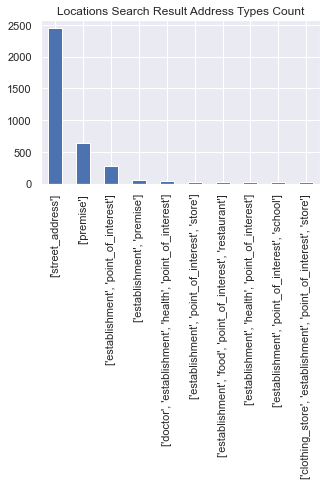

In [48]:
first_res['types'].value_counts().head(10).plot.bar(
    figsize=(5,3), title='Locations Search Result Address Types Count'
); plt.show()

---
# 5. Include geodecoded results to catalog

In [53]:
geocode_keep_cols = [
    'formatted_address', 'place_id',
    'types', 'lat', 'lng', 'location_type', 'route',
    'street_number', 'postal_code', 'premise', 
]

# catalog['search_index'] = np.arange(len(catalog))
selected_geocode = first_res[geocode_keep_cols].reset_index(drop=False).rename(columns={
    'search_id': 'EVENTO_ID',
    'lat': 'search_lat',
    'lng': 'search_lng'
})

full_catalog = pd.merge(  # auto exclude incidents without geocoded result
    catalog.reset_index(drop=False),
    selected_geocode,
    on='EVENTO_ID'
)

full_catalog.head()

,EVENTO_ID,EVENTO_TITULO,EVENTO_DESCRICAO,EVENTO_GRAVIDADE,EVENTO_BAIRRO,STATUS,EVENTO_PRAZO,POP_TITULO,POP_DESCRICAO,evento_inicio,...,formatted_address,place_id,types,search_lat,search_lng,location_type,route,street_number,postal_code,premise
0,111,Rompimento de adutora - Lagoa,"Avenida Borges de Medeiros, 3265 - Lagoa, Rio ...",MEDIO,NaN,FECHADO,NaN,Vazamento de água / esgoto,Vazamento de água / esgoto,2015-05-16 14:33:00,...,"Av. Borges de Medeiros, 3285 - Lagoa, Rio de J...",ChIJV7nTZHfVmwARCuQ3cTjS4yQ,['street_address'],-22.962579,-43.210340,ROOFTOP,Avenida Borges de Medeiros,3285,22470-001,Condomínio Edificio Campo de Gardenias
1,185,Vazamento em adutora - Rio Comprido - Dano em ...,"Rua Guaicurus, 54 - Rio Comprido",BAIXO,NaN,FECHADO,NaN,Vazamento de água / esgoto,Vazamento de água / esgoto,2015-06-02 11:55:00,...,"R. Guaicurus, 1 - Rio Comprido, Rio de Janeiro...",ChIJqbg2CrB_mQARbghgcWLoLcU,['street_address'],-22.926818,-43.203156,ROOFTOP,Rua Guaicurus,1,20251-100,NaN
2,301,Vazamento Água,"Avenida Borges de Medeiros, 3647 - Lagoa",BAIXO,NaN,FECHADO,NaN,Vazamento de água / esgoto,Vazamento de água / esgoto,2015-06-20 12:54:00,...,"Av. Borges de Medeiros, 3669 - Lagoa, Rio de J...",ChIJle_kZHrVmwARYySwO9w6ido,"['establishment', 'point_of_interest']",-22.962635,-43.206679,ROOFTOP,Avenida Borges de Medeiros,3669,22470-001,NaN
3,426,Afundamento de pista,Rua Gomes Carneiro-124 - Ipanema,BAIXO,NaN,FECHADO,NaN,Vazamento de água / esgoto,Vazamento de água / esgoto,2015-07-04 19:33:00,...,"R. Caning, 6 - Copacabana, Rio de Janeiro - RJ...",ChIJNWNRxxfVmwARA2d3WzQgmTY,"['establishment', 'premise']",-22.984814,-43.195270,ROOFTOP,Rua Caning,6,22081-040,NaN
4,440,Vazamento de Água,"Rua Prudente de Morais, 660 - Ipanema",BAIXO,NaN,FECHADO,NaN,Vazamento de água / esgoto,Vazamento de água / esgoto,2015-07-07 10:28:00,...,"R. Vinícius de Moraes, 53a - Ipanema, Rio de J...",ChIJx89kxhrVmwARUpJz5Ih_Yc8,['street_address'],-22.985166,-43.203040,ROOFTOP,Rua Vinícius de Moraes,53a,22411-010,NaN


### Measures of searched coordinates difference from original coordinates

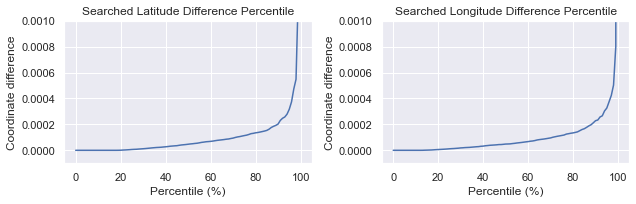

In [73]:
lat_diff = abs(full_catalog['search_lat'] - full_catalog['lat'])
lng_diff = abs(full_catalog['search_lng'] - full_catalog['lng'])
lat_prct, lng_prct = ( pd.Series(np.percentile(diff, range(101))) for diff in [lat_diff, lng_diff] )

fig, ax = plt.subplots(1, 2, figsize=(9, 3), tight_layout=True)
lat_prct.plot(ax=ax[0])
lng_prct.plot(ax=ax[1])
for i, col in zip([0,1], ['Latitude', 'Longitude']):
    ax[i].set(
        ylim=(-0.0001, 0.001),
        title=f'Searched {col} Difference Percentile',
        ylabel='Coordinate difference',
        xlabel='Percentile (%)'
    )
plt.show()

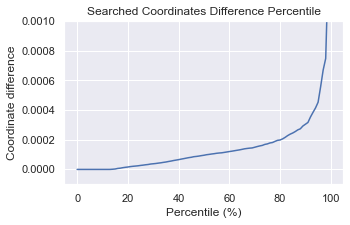

In [76]:
hypho_diff = (lat_diff**2 + lng_diff**2)**0.5
hypho_prct = pd.Series(np.percentile(hypho_diff, range(101)))

fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=False)
hypho_prct.plot(ax=ax)
ax.set(
    ylim=(-0.0001, 0.001),
    title=f'Searched Coordinates Difference Percentile',
    ylabel='Coordinate difference',
    xlabel='Percentile (%)'
); plt.show()

#### Drop results more than 0.0005 distant from originaal coordinates

In [83]:
# full_catalog = 
full_catalog[hypho_diff>0.0005]

,EVENTO_ID,EVENTO_TITULO,EVENTO_DESCRICAO,EVENTO_GRAVIDADE,EVENTO_BAIRRO,STATUS,EVENTO_PRAZO,POP_TITULO,POP_DESCRICAO,evento_inicio,...,formatted_address,place_id,types,search_lat,search_lng,location_type,route,street_number,postal_code,premise
205,4508,Bolsão D'água,"Estrada do Galeão, 3986-4726 - Portuguesa",BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2016-03-24 01:57:00,...,"Estrada do Galeão, 4365 - Meier, Rio de Janeir...",ChIJ4RSQrsl5mQARBBh9S_PYrGM,['street_address'],-22.813667,-43.220397,ROOFTOP,Estrada do Galeão,4365,21941-353,NaN
207,6472,Bolsão d'água,Mergulhão Billy Blanco - Barra,BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2016-06-07 09:13:00,...,"Barra da Tijuca, Rio de Janeiro - RJ, 22630, B...",ChIJ_4m1OU_amwARIL5PthwjqhQ,"['postal_code', 'postal_code_prefix']",-23.004181,-43.360841,APPROXIMATE,Avenida das Américas,NaN,22640-102,NaN
241,11780,Bolsão de Água,Av. Borges de Medeiros - Lagoa - Alt. da Saída...,BAIXO,NaN,FECHADO,NaN,Bolsão d'água em via,Bolsão d'água em via,2016-11-05 17:04:00,...,"R. 6, 35 - Lagoa, Rio de Janeiro - RJ, Brasil",ChIJNRKTY6HVmwAR9tPIskKmSJU,['premise'],-22.972268,-43.218023,ROOFTOP,Rua 6,35,NaN,NaN
270,13328,Rompimento de Adutora,"Estr. do Lameirão, 1030 - Santíssimo - Alt. R....",BAIXO,NaN,FECHADO,NaN,Vazamento de água / esgoto,Vazamento de água / esgoto,2017-01-04 11:54:00,...,"Estr. do Lameirão, 39925 - Santíssimo, Rio de ...",ChIJ0VnlaMjhmwARwAdcwZPYE58,['street_address'],-22.861107,-43.531602,ROOFTOP,Estrada do Lameirão,39925,23092-031,NaN
310,14448,Vazamento de Água,"AutoEstrada Grajaú - JPA, Km 1,5",BAIXO,NaN,FECHADO,NaN,Vazamento de água / esgoto,Vazamento de água / esgoto,2017-02-15 07:09:00,...,"Rio de Janeiro - RJ, 20720, Brasil",ChIJ8z1IddbXmwARbiU1Pv7iaKg,"['postal_code', 'postal_code_prefix']",-22.926994,-43.293239,APPROXIMATE,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817,72896,Bolsão d'água em via,"Av. Borges de Medeiros, Alt. R. Gen. Tasso Fra...",BAIXO,Lagoa,FECHADO,CURTO,Bolsão d'água em via,Bolsão d'água em via,2022-04-01 21:58:00,...,"R. 6, 35 - Lagoa, Rio de Janeiro - RJ, Brasil",ChIJNRKTY6HVmwAR9tPIskKmSJU,['premise'],-22.972268,-43.218023,ROOFTOP,Rua 6,35,NaN,NaN
3818,72897,Bolsão d'água em via,"Avenida Borges de Medeiros, Alt. Av. Lineu de ...",BAIXO,Lagoa,FECHADO,CURTO,Bolsão d'água em via,Bolsão d'água em via,2022-04-01 22:00:00,...,"R. 6, 35 - Lagoa, Rio de Janeiro - RJ, Brasil",ChIJNRKTY6HVmwAR9tPIskKmSJU,['premise'],-22.972268,-43.218023,ROOFTOP,Rua 6,35,NaN,NaN
3820,72901,Bolsão d'água em via ( Cam 259 ),Av. Borges De Medeiros - Alt. Parque dos Patin...,MEDIO,Lagoa,ABERTO,CURTO,Bolsão d'água em via,Bolsão d'água em via,2022-04-01 22:11:00,...,"R. 6, 35 - Lagoa, Rio de Janeiro - RJ, Brasil",ChIJNRKTY6HVmwAR9tPIskKmSJU,['premise'],-22.972268,-43.218023,ROOFTOP,Rua 6,35,NaN,NaN
3840,72934,Bolsão d'água em via,Avenida Borges de Medeiros - Alt. Parque dos P...,BAIXO,Lagoa,FECHADO,CURTO,Bolsão d'água em via,Bolsão d'água em via,2022-04-02 06:03:00,...,"R. 6, 35 - Lagoa, Rio de Janeiro - RJ, Brasil",ChIJNRKTY6HVmwAR9tPIskKmSJU,['premise'],-22.972268,-43.218023,ROOFTOP,Rua 6,35,NaN,NaN


### Save and reload final catalog of incidents

In [58]:
# full_catalog.to_csv('dados/incident_catalog.csv', index=False)
full_catalog = pd.read_csv('dados/incident_catalog.csv')

full_catalog.shape

(3987, 23)

---
# 6. EXTRA: Search for missing incidents of specific categories in text records

#### Function to search for terms in pandas series of type string

In [60]:
def drop_accents(string):
    item = string.lower()
    for a, b in zip(
        ['á', 'ã', 'â', 'é', 'í', 'ó', 'õ', 'ú', 'ç'],
        ['a', 'a', 'a', 'e', 'i', 'o', 'o', 'u', 'c']
    ):
        item = item.replace(a, b)
    return item

def search_records(records, queries, avoid=[], report_interval=10000): # accepts records argument as pandas series
    matches = []
    for i, index in enumerate(records.index):
        if i%report_interval == 0: print(f'{i+1}/{records.shape[0]} records searched'); co(wait=True)
        record = records.loc[index]
        if type(record)==str:
            record = drop_accents(record)
            query_matches, match_words = [], []
            for query in queries:
                if drop_accents(query) in record:
                    words = record.split(' ')
                    for word in words:
                        if query in word:
                            if word not in avoid:
                                match_words.append(word)
                    if match_words:
                        query_matches.append(query)
            if query_matches:
                matches.append([index, query_matches, match_words])
    print(f'Done! {len(records)} terms searched.')
    return pd.DataFrame(matches, columns=['index', 'matched_queries', 'matched_words'])

### Term search for specific incident categories in text records left out of initial extracting

In [61]:
queries = [
    'bolsao', 'bolsoes', 'alagamento',
    'lamina', 'espelho', 'enchente',
    'inundacão', 'vazamento', 'bueiro',
    'rompimento', 'adutora', 'tubulação'
]

term_search = search_records(records_left['EVENTO_TITULO'], queries, avoid=[]) # searching in records left out of initial extraction

Done! 192732 terms searched.


In [62]:
term_search['matched_queries'].value_counts().to_frame()

,matched_queries
[bueiro],404
[vazamento],307
"[rompimento, tubulação]",12
[alagamento],11
[adutora],7
"[vazamento, bueiro]",5
[bolsao],1


---
# 7. Extra: Searching incidents identified by city cameras

#### Search for 'cam' term in text records

In [63]:
cam_search = search_records(full_catalog['EVENTO_TITULO'], queries=['cam'])

cam_search['matched_words'].value_counts()

Done! 3987 terms searched.


[cam]         142
[(cam]         72
[(camera]      58
[cam.]          6
[(cam.]         5
[camera]        1
[(cam278)]      1
[(cam48)]       1
[(cam269)]      1
[(cam145)]      1
[(cam107)]      1
[(cam116)]      1
[(cam147)]      1
[(cam262)]      1
[(cam430)]      1
[(cam298)]      1
[(cam354)]      1
[(cam243)]      1
[(cam112)]      1
Name: matched_words, dtype: int64

#### Percentage of incidents identified by camera

In [64]:
cam_records = full_catalog.loc[cam_search['index']]

print(round(cam_records.shape[0] / full_catalog.shape[0] * 100, 2), '%')

7.45 %


In [65]:
cam_records['POP_TITULO'].value_counts().to_frame()

,POP_TITULO
Bolsão d'água em via,263
Vazamento de água / esgoto,14
Alagamento,9
Lâmina d'água,8
Bueiro,3
